In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os
import cv2 as cv
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

# Define the data and label

In [2]:
def getlabel(dir):
    labels=[]
    for name in os.listdir(dir):
        if os.path.splitext(name)[1] == '.JPG':
            fname=os.path.splitext(name)[0]
            fname=fname.split('-')[1]
            labels.append(fname)
    labels = list(map(float, labels))
    labels = torch.tensor(labels)
    # Normalize labels
    #min = torch.min(labels)
    #max = torch.max(labels)
    #labels = (labels - min) / (max - min)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return labels

def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    train_data = []
    for file_name in os.listdir(dir):
        if file_name != "Thumbs.db":
            img_dir = os.path.join(dir, file_name)
            img = cv.imread(img_dir)
            #img = cv.resize(img, (769, 432))   # /5 resize img
            #img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
            pimg = Image.fromarray(img)
            train_data.append(pimg)
    return train_data

In [3]:
traindir= './train/'
validdir = './valid/'
train_data0 = generate_dataset(traindir)
train_label0=getlabel(traindir)
valid_data0 = generate_dataset(validdir)
valid_label0 = getlabel(validdir)


In [4]:
train_label0

tensor([[  0.0000],
        [ 20.0000],
        [ 28.0000],
        [ 35.0000],
        [ 37.0000],
        [ 39.0000],
        [ 42.0000],
        [ 48.0000],
        [ 51.0000],
        [ 62.0000],
        [ 72.0000],
        [ 75.0000],
        [ 81.0000],
        [ 97.0000],
        [ 96.0000],
        [105.0000],
        [111.0000],
        [118.0000],
        [124.0000],
        [135.0000],
        [140.0000],
        [146.0000],
        [154.0000],
        [165.0000],
        [161.0000],
        [158.0000],
        [154.0000],
        [150.0000],
        [146.0000],
        [143.0000],
        [138.0000],
        [135.0000],
        [133.0000],
        [130.0000],
        [127.0000],
        [124.0000],
        [122.0000],
        [119.0000],
        [116.0000],
        [110.0000],
        [107.0000],
        [103.0000],
        [ 96.0000],
        [ 94.0000],
        [ 92.0000],
        [ 90.0000],
        [ 86.0000],
        [ 84.0000],
        [ 81.0000],
        [ 80.5000],


# 重写dataset类

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)
    

# 用MyDataset构建数据集

In [6]:
normMean = [0.5, 0.5, 0.5]
normStd = [0.5, 0.5, 0.5]
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]   
    #transforms.Normalize(normMean, normStd)
    ])

# 也可以再定义train_transform加入一些数据增强 
train_data = MyDataset(train_data0, train_label0, transform=transform)
valid_data = MyDataset(valid_data0, valid_label0, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=5, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([5, 1, 2400, 2400])
torch.Size([5, 1])


# 定义网络

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
    
    def forward(self,x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x+y)

In [9]:
class Net(torch.nn.Module):
    # Net类的初始化函数
    def __init__(self):
        # 继承父类的初始化函数
        super(Net, self).__init__()
        # 网络的隐藏层创建，名称可以随便起
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=10, stride=2)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=10, stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(12)
        #residual
        self.rblock1 = ResidualBlock(12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.rblock2 = ResidualBlock(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=2, stride=1)
        self.bn5 = nn.BatchNorm2d(48)
        self.rblock3 = ResidualBlock(48)
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=2, stride=1)
        self.bn6 = nn.BatchNorm2d(96)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(96*8*8, 3072)
        self.fc2 = nn.Linear(3072,500)
        self.fc3 = torch.nn.Linear(500, 100)
        # 输出层(预测层)创建，接收来自隐含层的数据
        self.predict_layer = torch.nn.Linear(100, 1)

    # 网络的前向传播函数，构造计算图
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))     #(2400-10)/2+1=1196
        x = self.pool(x)                        #1196/2=598
        x = F.relu(self.bn2(self.conv2(x)))     #(598+2-10)/2+1=296
        x = self.pool(x)                        #296/2=148
        x = F.relu(self.bn3(self.conv3(x)))     #(148-5)/1+1=144
        x = self.pool(x)                        #144/2=72
        x = self.rblock1(x)
        x = F.relu(self.bn4(self.conv4(x)))     #(72-3)/1+1=70
        x = self.pool(x)                        #70/2=35
        x = self.rblock2(x)
        x = F.relu(self.bn5(self.conv5(x)))     #(35-2)/1+1=34
        x = self.pool(x)                        #34/2=17
        x = self.rblock3(x)
        x = F.relu(self.bn6(self.conv6(x)))     #17-2+1=16
        x = self.pool(x)                        #16/2=8
        x = x.view(-1, 96*8*8)
        # 用relu函数处理隐含层输出的结果并传给输出层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        predict_result = self.predict_layer(x)
        return predict_result

In [10]:
def testAccuracy():
    
    net.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            print('Prediction data is:',prediction.data.cpu().numpy()[0])
            print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)

            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            print('epoch:',i*epoch,'loss:',loss.item())
            mseloss.append(loss.data.cpu().numpy())
            trainnum.append(i*epoch)
            
            running_loss += loss.item()
            if i % 100 == 99:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                # zero the loss
                running_loss = 0.0
            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

            #if i % 2 == 0:
            # plot and show learning process
            #     plt.cla()
            #     # 无误差真值曲线
            #     plt.plot(labels.cpu().numpy(), labels.cpu().numpy(), c='blue', lw='3')
            #     # 实时预测的曲线
            #     plt.scatter(labels.data.cpu().numpy()[0], prediction.data.cpu().numpy()[0])
            #     plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})
            #     plt.pause(0.1)
        # # 计算准确率
        # # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))


    print('Finished Training')
    
    plt.figure()
    plt.plot()
    plt.plot(train_label0.data.numpy(), train_label0.data.numpy(), c='Red', lw='3')
    plt.scatter(predata,labeldata)
    plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})

    
    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(trainnum,mseloss)


In [11]:
Vdataiter=iter(valid_loader)
vimg, vlabels = Vdataiter.next()
print(vimg.shape)
print(vlabels.shape)
print(vlabels)

torch.Size([5, 1, 2400, 2400])
torch.Size([5, 1])
tensor([[140.0000],
        [109.0000],
        [ 32.0000],
        [ 31.5000],
        [ 76.0000]])


## 预测结果

In [12]:
def predict(model, device):
    Vdataiter=iter(valid_loader)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        #_, pre = torch.max(out.data, 1)
        return out, vlabels

# 定义模型

In [13]:
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.001

# 定义模型
net = Net()
print(net)
# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = torch.nn.MSELoss() # 定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

Net(
  (conv1): Conv2d(1, 3, kernel_size=(10, 10), stride=(2, 2))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(3, 6, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rblock2): ResidualBlock(
    (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  

# 主函数

Prediction data is: [0.04900451]
label data is:  [[ 65.]
 [154.]
 [108.]
 [ 37.]
 [ 26.]]
epoch: 0 loss: 8324.6259765625
Prediction data is: [7.3298626]
label data is:  [[146. ]
 [178. ]
 [165.5]
 [137.5]
 [166. ]]
epoch: 0 loss: 23149.998046875
Prediction data is: [29.619879]
label data is:  [[175.]
 [ 84.]
 [ 76.]
 [107.]
 [ 81.]]
epoch: 0 loss: 7003.28125
Prediction data is: [72.51132]
label data is:  [[ 39. ]
 [ 42. ]
 [ 41.5]
 [105.5]
 [ 42. ]]
epoch: 0 loss: 950.6410522460938
Prediction data is: [96.692566]
label data is:  [[154.]
 [ 43.]
 [  8.]
 [146.]
 [143.]]
epoch: 0 loss: 3487.961669921875
Prediction data is: [128.879]
label data is:  [[ 24.5]
 [ 72. ]
 [ 92. ]
 [164. ]
 [ 80.5]]
epoch: 0 loss: 3465.847412109375
Prediction data is: [103.83796]
label data is:  [[ 28. ]
 [165. ]
 [ 74. ]
 [ 81. ]
 [ 97.5]]
epoch: 0 loss: 2097.09375
Prediction data is: [77.644356]
label data is:  [[146. ]
 [105. ]
 [116.5]
 [107. ]
 [115. ]]
epoch: 0 loss: 1907.2066650390625
Prediction data is

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Finished Training
(tensor([[ 53.5511],
        [138.3569],
        [ 50.6106],
        [130.4083],
        [ 78.4900]], device='cuda:0'), tensor([[ 44.0000],
        [ 99.0000],
        [ 31.5000],
        [120.0000],
        [101.0000]]))


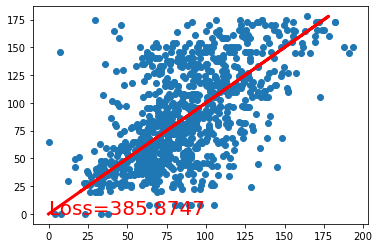

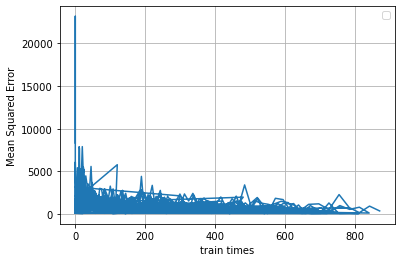

In [14]:
# Vdataiter=iter(valid_loader)
# vimg, vlabels = Vdataiter.next()
# print(vimg.shape)
# print(vlabels.shape)
# print(vlabels)
if __name__ == "__main__":

    torch.cuda.empty_cache()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    # Let's build our model
    train(30)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))

    print(predict(net, device))


In [15]:
print(predict(net, device))

(tensor([[ 78.4900],
        [ 79.1134],
        [ 82.1618],
        [100.1420],
        [ 53.5511]], device='cuda:0'), tensor([[101.],
        [ 32.],
        [105.],
        [101.],
        [ 44.]]))
